# Día 1 — Conceptos básicos

````{admonition} Resumen
:class: tip

**Objetivo del día:** Comprender la naturaleza matricial de las imágenes, los espacios de color más usados (BGR/RGB/GRAY) y dominar las operaciones básicas E/S (imágenes y vídeo) y conversión de color en OpenCV. Dominar la estructura de una imagen como `numpy.ndarray` (análoga a `cv::Mat`), y asentar bases matemáticas mínimas: tensores y color lineal vs. no lineal.

**Requisitos:** Python ≥ 3.9, `opencv-python`, `numpy`, `matplotlib`.


## Índice
1. Ecosistema y conceptos clave
2. `cv::Mat` vs `numpy.ndarray`: dtype, shape, strides, memoria
3. Canales de color: BGR/RGB/GRAY y conversión
4. ROI, copia vs. vista (copy vs. view)
5. E/S de imágenes: `imread`, `imwrite`
6. Vídeo con `VideoCapture`
7. Cronometría: copias vs. vistas
8. **Stretch**: `safe_imread` robusto
9. Ejercicios (con soluciones ocultables)
10. Lecturas y referencias


## 1. Conceptos clave y fundamentos matemáticos

### 1.1 Imagen como función/matriz
Una imagen digital puede modelarse como una función **muestrada y cuantizada**:

$$
I:\Omega \subset \mathbb{Z}^2 \to \mathbb{R}^C,\quad I(x,y) = \big(I_1(x,y),\dots,I_C(x,y)\big)
$$

donde:
- $(x,y)$ son coordenadas de píxel en una retícula regular,
- $C$ es el número de canales (1 en escala de grises, 3 en color),
- la intensidad suele estar cuantizada en 8 bits `uint8`$(0$–$255)$ o en punto flotante normalizado `float32` $[0,1]$.

### 1.2 Imágenes como tensores

Desde un punto de vista matemático, una imagen digital puede entenderse como un **tensor**: una estructura multidimensional que contiene valores numéricos organizados en ejes.  

- Una imagen en **escala de grises** se representa como un tensor de orden 2:  $I \in \mathbb{R}^{H \times W}$ donde $(H)$ es la altura (número de filas) y $(W)$ el ancho (número de columnas).  Cada elemento $I_{ij}$ representa la intensidad luminosa del píxel en la fila $i$ y columna $j$.

- Una imagen **en color**, en cambio, se representa como un tensor de orden 3: $I \in \mathbb{R}^{H \times W \times C}$ donde $C = 3$ corresponde a los tres canales de color (por ejemplo, **BGR** en OpenCV o **RGB** en Matplotlib).

Cada canal codifica una **componente espectral** de la luz. Así, un píxel completo puede expresarse como un vector tridimensional:

$$
\mathbf{p}_{ij} = 
\begin{bmatrix}
B_{ij} \\ 
G_{ij} \\ 
R_{ij}
\end{bmatrix}
$$

en el espacio de color BGR.  

En operaciones matriciales, estas imágenes se tratan como tensores en los que las operaciones (suma, resta, multiplicación escalar, etc.) se aplican **por elemento**. `NumPy` facilita estas operaciones mediante el **broadcasting**, que ajusta automáticamente las dimensiones compatibles.

```{tip}
El broadcasting en `NumPy` es un mecanismo inteligente que permite realizar operaciones aritméticas entre arrays de diferentes dimensiones de forma automática y eficiente, sin necesidad de duplicar físicamente los datos en memoria. Este sistema funciona mediante reglas bien definidas que comparan las dimensiones de los arrays desde la derecha hacia la izquierda, determinando su compatibilidad cuando las dimensiones son iguales, cuando una de ellas es 1, o cuando una dimensión no existe en uno de los arrays. En esencia, el broadcasting "estira" virtualmente los arrays más pequeños para que coincidan con la forma del array más grande, permitiendo operaciones elemento por elemento que de otra manera requerirían costosos bucles o replicaciones explícitas de datos.

Esta funcionalidad no solo hace que el código sea más conciso y legible, sino que también mejora significativamente el rendimiento al vectorizar las operaciones internamente. Por ejemplo, cuando sumamos un escalar a un array multidimensional, NumPy automáticamente propaga ese valor único a través de todos los elementos del array, o cuando operamos entre un vector fila y una matriz, el sistema replica inteligentemente el vector a lo largo de las dimensiones necesarias. Sin embargo, el broadcasting tiene sus límites y falla cuando las dimensiones de los arrays son fundamentalmente incompatibles según las reglas establecidas, protegiendo así al usuario de resultados erróneos. Esta característica constituye una piedra angular en aplicaciones científicas y de machine learning, donde las operaciones entre datasets de distintas formas son frecuentes y la eficiencia computacional es crucial.

```

## 2. Espacios de color

### 2.1 Conceptos fundamentales

Un **espacio de color** es una forma de representar los colores posibles dentro de un modelo matemático determinado. Los más comunes son:

- **RGB / BGR**: El espacio de color RGB (Red, Green, Blue) es un modelo de color aditivo fundamental en la representación digital de imágenes, basado en la combinación de tres componentes luminosos primarios: rojo, verde y azul. RGB opera mediante la síntesis aditiva de luz, donde diferentes intensidades de estos tres canales se mezclan para producir la gama completa de colores visibles, desde el negro absoluto (cuando todos los valores son cero) hasta el blanco puro (cuando los tres componentes alcanzan su máxima intensidad). La estructura de RGB lo hace extremadamente eficiente para el procesamiento computacional y el almacenamiento de datos de imagen, aunque resulta menos intuitivo cuando se intentan realizar ajustes cromáticos específicos, ya que modificaciones aparentemente simples como cambiar el tono de un color requieren alteraciones coordinadas en los tres canales simultáneamente. `BGR` es el espacio de color por defecto de OpenCV. Mantiene la misma base funcional aunque el orden de los tres canales es azul (B), verde (G) y rojo (R).
  
- **GRAY**: También conocido como escala de grises, es un modelo de representación cromática que reduce toda la información de color a un único canal de intensidad lumínica, eliminando por completo los componentes de tonalidad y saturación. En este sistema unidimensional, cada píxel se representa mediante un valor numérico que exclusivamente codifica su nivel de brillo, oscilando típicamente entre el negro absoluto (valor 0) y el blanco puro (valor máximo, usualmente 255 en imágenes de 8 bits), con toda la gama de grises intermedios distribuidos proporcionalmente según su luminosidad perceptual. Esta transformación se calcula generalmente mediante una fórmula ponderada que combina los canales originales RGB:
$
0.299 \cdot R + 0.587 \cdot G + 0.114 \cdot B
$
donde los coeficientes reflejan la sensibilidad diferencial del ojo humano a cada color primario, priorizando el verde sobre el rojo y el azul para lograr una conversión perceptualmente precisa. Al descartar toda la información cromática y conservar únicamente los datos de luminancia, el espacio GRAY resulta especialmente útil para aplicaciones de procesamiento de imágenes que se centran en análisis estructural, detección de bordes, reconocimiento de patrones o cualquier tarea donde la información de textura y contraste sea más relevante que el color mismo, además de ofrecer una significativa reducción en la complejidad computacional y los requisitos de almacenamiento al trabajar con un solo canal en lugar de tres.
    
- **HSV**: El espacio de color HSV (Hue, Saturation, Value) es un modelo de representación cromática que organiza los colores de forma más intuitiva que el tradicional RGB, basándose en cómo los seres humanos perciben y describen los atributos del color. En este sistema tridimensional, el **Matiz (Hue)** se representa como un círculo cromático continuo donde cada ángulo corresponde a un color puro específico, desde el rojo en 0° hasta los violetas en 360°. La **Saturación (Saturation)** controla la intensidad o pureza del color, variando desde tonos grisáceos neutros en el valor mínimo hasta colores completamente vivos y puros en el máximo. El **Valor (Value)** determina la luminosidad general, escalando desde el negro absoluto hasta el máximo brillo del color, independientemente de su tono. Esta separación entre el aspecto cromático (matiz), la intensidad del color (saturación) y el brillo (valor) permite manipulaciones más naturales en aplicaciones de edición gráfica, selección de paletas de colores y procesamiento de imágenes, ya que los usuarios pueden ajustar cada componente perceptual por separado sin afectar necesariamente a los demás, facilitando operaciones como cambiar tonos específicos, ajustar contraste o crear degradados armónicos.

- **LAB**: El espacio de color LAB, también conocido como CIELAB, es un modelo de color diseñado para ser perceptualmente uniforme, lo que significa que las distancias matemáticas entre colores en este espacio se correlacionan directamente con las diferencias percibidas por el ojo humano. Organizado en tres ejes, la `L` representa la luminosidad* (desde el negro 0 hasta el blanco 100), el eje `A` define la posición entre el verde (valores negativos) y el rojo (valores positivos), y el eje `B` representa la posición entre el azul (valores negativos) y el amarillo (valores positivos). A diferencia de los espacios dependientes de dispositivos como RGB, LAB es un espacio de color independiente y pretende encapsular todo el rango de colores que los humanos pueden percibir. Esta característica lo hace particularmente valioso en aplicaciones de edición de imágenes avanzada, control de calidad de color en la industria, y algoritmos de visión por computadora donde la percepción visual precisa y la consistencia del color bajo diferentes condiciones de iluminación son fundamentales, ya que permite ajustes de color que resultan más intuitivos y visualmente coherentes.

- **YCrCb**:  Este espacio de color es un modelo de representación cromática que separa la información de una imagen en tres componentes distintos: `Y` representa la luminancia (componente de brillo), `Cb` codifica la diferencia entre el componente azul y la luminancia, y `Cr` representa la diferencia entre el componente rojo y la luminancia. Este sistema se diseñó específicamente para sistemas de video y compresión de imágenes digitales, aprovechando la menor sensibilidad del ojo humano a las variaciones cromáticas en comparación con las variaciones de brillo. Al separar la información de luminancia de la crominancia, YCbCr permite aplicar técnicas de submuestreo (como 4:2:2 o 4:2:0) donde la información de color se almacena con menor resolución que la información de brillo sin pérdidas perceptibles significativas en la calidad visual. Esta característica lo hace fundamental en estándares de compresión ampliamente utilizados como JPEG para imágenes estáticas y MPEG/H.264 para video digital, donde se logran altas tasas de compresión al reducir selectivamente los datos cromáticos mientras se preserva la calidad en los detalles estructurales capturados por el componente de luminancia. 

OpenCV gestiona internamente las imágenes en el espacio de color BGR (Blue-Green-Red) debido a condicionantes históricos vinculados a las primeras implementaciones de bibliotecas de visión artificial y a convenciones heredadas de los primeros sistemas de captura. Esta particularidad genera una discrepancia fundamental con la mayoría de ecosistemas de visualización (como `Matplotlib` o `PIL/Pillow`) que operan bajo el estándar RGB (Red-Green-Blue), estructura alineada con los modelos perceptuales humanos y los espacios colorimétricos convencionales.

Para resolver esta disonancia estructural, OpenCV incorpora mecanismos de transformación bidireccional mediante funciones especializadas en conversión de espacios de color `cv2.Color()` , permitiendo una transposición eficiente y sin pérdida de información entre ambos modelos mediante operaciones de reordenamiento canales. Esta capa de abstracción garantiza la interoperabilidad entre subsistemas de procesamiento y visualización, simplificando flujos de trabajo en *pipelines* de procesamiento de imágenes donde la coherencia en la representación cromática es crucial para el análisis cuantitativo y la interpretación visual de resultados.

### 2.2 Modelos matemáticos simplificados

- **HSV (normalizado):**
  Sea $(R,G,B)\in[0,1]^3$, $M=\max(R,G,B)$, $m=\min(R,G,B)$, $\Delta=M-m$.

  
  $$
  V=M,\quad S=\begin{cases}
  0 & \text{si } M=0,\\
  \Delta/M & \text{en otro caso}
  \end{cases}
  $$
  
  El **tono** $H$ (en grados) es:

  ```{math}
  H = \begin{cases}
  0 & \Delta=0,\\
  60^\circ \cdot \big((G-B)/\Delta \bmod 6\big) & M=R,\\
  60^\circ \cdot \big((B-R)/\Delta + 2\big) & M=G,\\
  60^\circ \cdot \big((R-G)/\Delta + 4\big) & M=B.
  \end{cases}
  ```
  
- **YCrCb (BT.601):**

  ```{math}
  Y  = 0.299R + 0.587G + 0.114B,\quad
  Cb = \frac{B - Y}{1.772},\quad
  Cr = \frac{R - Y}{1.402}.
  ```
  ```{tip}
  Los coeficientes estándares BT.601 y BT.709 son especificaciones técnicas desarrolladas por la Unión Internacional de Telecomunicaciones (ITU) que definen los parámetros para la conversión entre espacios de color en sistemas de video y televisión digital.

  BT.601 (Recomendación ITU-R BT.601), también conocido como "Rec. 601", fue establecido originalmente para la televisión digital estándar (SDTV) y se utiliza principalmente para contenido de definición estándar con resoluciones como 720x480 (NTSC) y 720x576 (PAL). Sus coeficientes para la conversión a YCbCr reflejan las características de los CRT tradicionales y emplean las siguientes ponderaciones: Y = 0.299R + 0.587G + 0.114B.

  BT.709 (Recomendación ITU-R BT.709), conocido como "Rec. 709", fue desarrollado para televisión de alta definición (HDTV) y constituye el espacio de color estándar para contenido HD y Full HD. Este estándar utiliza coeficientes diferentes: Y = 0.2126R + 0.7152G + 0.0722B, que están optimizados para las tecnologías de pantalla moderna como LCD, plasma y OLED, reflejando una mayor sensibilidad al verde acorde con la percepción visual humana contemporánea y las capacidades de los dispositivos de visualización actuales.

  La diferencia fundamental entre ambos radica en que BT.709 asigna más peso al componente verde, reconociendo su mayor importancia en la percepción de luminancia por el ojo humano en sistemas de alta definición, mientras que BT.601 mantiene una distribución más equilibrada entre rojo y verde para los sistemas de definición estándar. En OpenCV, la conversión utiliza por defecto los coeficientes BT.601, pero puede especificarse el estándar deseado mediante parámetros adicionales en las funciones de procesamiento de video.
  ```
  
- **LAB** se define una serie de pasos intermedios que comprenden: RGB→CIE XYZ (lineal), normalización con iluminante de referencia, transformación no lineal XYZ→LAB (no lineal).

  - Conversión RGB → CIE XYZ
 
    ```{math}
    \begin{aligned}
    X &= 0.412453 \cdot R + 0.357580 \cdot G + 0.180423 \cdot B \\
    Y &= 0.212671 \cdot R + 0.715160 \cdot G + 0.072169 \cdot B \\
    Z &= 0.019334 \cdot R + 0.119193 \cdot G + 0.950227 \cdot B
    \end{aligned}
    ```

  - Normalización con Iluminante de Referencia (D65)
 
    ```{math}
    \begin{aligned}
    X_n &= 0.950456 \\
    Y_n &= 1.000000 \\
    Z_n &= 1.088754 \\
    \\
    X' &= \frac{X}{X_n} \\
    Y' &= \frac{Y}{Y_n} \\
    Z' &= \frac{Z}{Z_n}
    \end{aligned}
    ``` 


  - Función de transformación no lineal
 
    ```{math}
    f(t) = 
    \begin{cases}
    t^{1/3} & \text{si } t > 0.008856 \\
    7.787 \cdot t + \frac{16}{116} & \text{si } t \leq 0.008856
    \end{cases}
    ```

  - Coordenadas LAB
 
    ```{math}
    \begin{aligned}
    L^* &= 116 \cdot f(Y') - 16 \\
    a^* &= 500 \cdot \left[f(X') - f(Y')\right] \\
    b^* &= 200 \cdot \left[f(Y') - f(Z')\right]
    \end{aligned}
    ``` 

### 2.3. Espacio de color lineal vs. no lineal (gamma)

Las cámaras y pantallas **no capturan ni muestran la luz de forma lineal** con respecto a la energía luminosa.  

Por motivos fisiológicos y técnicos, la mayoría de las imágenes digitales usan el espacio `sRGB`, que aplica una **corrección gamma**: una función no lineal que comprime los valores de luminancia.

- En un espacio **lineal**, la intensidad $L$ es **proporcional** a la energía luminosa real.
- En un espacio **no lineal (sRGB)**, el valor almacenado $V$ está relacionado con $L$ por una potencia gamma:
  $$
  V = L^{1/\gamma}, \quad  \gamma \approx 2.2
  $$
  
  y su inversa:
  $$
  L = V^{\gamma}
  $$

Por tanto, para realizar cálculos físicos o matemáticos (por ejemplo, combinaciones de imágenes, promedios, o ajustes de exposición) debemos **linealizar** la imagen:
  
1. Normalizar los valores de 8 bits a rango $[0, 1]$:
   $$
   V' = \frac{V}{255}
   $$
2. Aplicar la corrección inversa:
   $$
   L = (V')^{\gamma}
   $$

Y una vez terminados los cálculos, para visualizar correctamente en pantalla debemos **reaplicar la gamma directa**:
$$
V' = L^{1/\gamma}, \quad V = 255 \cdot V'
$$

````{warning} Ejemplo
Supongamos dos píxeles con valores de luminancia física $0.25$ y $0.50$.  

En el espacio **lineal**, el segundo es exactamente el doble de brillante.  Sin embargo, en sRGB (no lineal):

$$
V_1 = (0.25)^{1/2.2} \approx 0.53,\quad
V_2 = (0.50)^{1/2.2} \approx 0.73
$$

Al convertir de nuevo a 8 bits, los valores son 135 y 186, y **la diferencia ya no es lineal**: el ojo humano percibe el segundo píxel menos de “el doble” de brillante, ajustando la percepción a la realidad visual.
````

```{admonition} Conclusión práctica

- Para **visualizar imágenes**, se usa sRGB (no lineal).  
- Para **procesarlas matemáticamente** (promedios, convoluciones, blending, etc.), conviene transformarlas a un **espacio lineal** y al finalizar re-aplicar la gamma inversa para visualizar.
- OpenCV no aplica corrección gamma de forma automática: los valores que devuelve `cv2.imread()` están en el espacio sRGB estándar (no lineal).  

En resumen, comprender los espacios de color y la diferencia entre representaciones lineales y no lineales es esencial para evitar errores de interpretación en la intensidad, el brillo o las operaciones matemáticas sobre imágenes.
````

## 3. Operaciones fundamentales

In [2]:
# IMPORTACIÓN DE LIBRERÍAS

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Ajustes de visualización en notebook
plt.rcParams['figure.figsize'] = (8, 6)

print(f"La versión de OpenCV instalada es: {cv2.__version__}")


La versión de OpenCV instalada es: 4.12.0


### 3.1 E/S de imágenes: `imread`, `imwrite` y comprobaciones básicas

La función usada para leer imágenes es: `v2.imread(filename, flags=int) → retval` en donde:

- `filename`: es la ruta completa o relativa del archivo de imagen a cargar
- `flags`: es un entero opcional que especifica como cargar la imagen con los siguientes valores posibles:
  + `cv2.IMREAD_COLOR` o 1: Carga imagen a color (BGR, 8-bit por canal)
  + `cv2.IMREAD_GRAYSCALE` o 0: Carga imagen en escala de grises
  + `cv2.IMREAD_UNCHANGED` o -1: Carga imagen incluyendo canal alfa
  + `cv2.IMREAD_ANYDEPTH`: Carga imagen con profundidad original
  + `cv2.IMREAD_ANYCOLOR`: Carga imagen en cualquier formato de color
  + `cv2.IMREAD_REDUCED_GRAYSCALE_2`: Escala de grises reducida a 1/2
  + `cv2.IMREAD_REDUCED_COLOR_2`: Color reducido a 1/2
  + `cv2.IMREAD_REDUCED_GRAYSCALE_4`: Escala de grises reducida a 1/4
  + `cv2.IMREAD_REDUCED_COLOR_4`: Color reducido a 1/4
  + `cv2.IMREAD_REDUCED_GRAYSCALE_8`: Escala de grises reducida a 1/8
  + `cv2.IMREAD_REDUCED_COLOR_8`: Color reducido a 1/8

El valor por defecto es `cv2.IMREAD_COLOR`.

```{admonition} Recuerda que:
OpenCV emplea el espacio de color BGR (Blue-Green-Red) en lugar del estándar RGB (Red-Green-Blue). Esta discrepancia en el orden de los canales tiene consecuencias críticas al interoperar con otras bibliotecas del ecosistema Python. Matplotlib, PIL/Pillow, Scikit-image y la mayoría de herramientas de visualización esperan imágenes en formato RGB estándar. Si se visualiza directamente una imagen cargada con OpenCV sin realizar la conversión adecuada, se produce una distorsión cromática sistemática donde los tonos rojos y azules aparecen intercambiados, comprometiendo la fidelidad del color y invalidando cualquier análisis visual o cuantitativo basado en la apariencia cromática. 
```



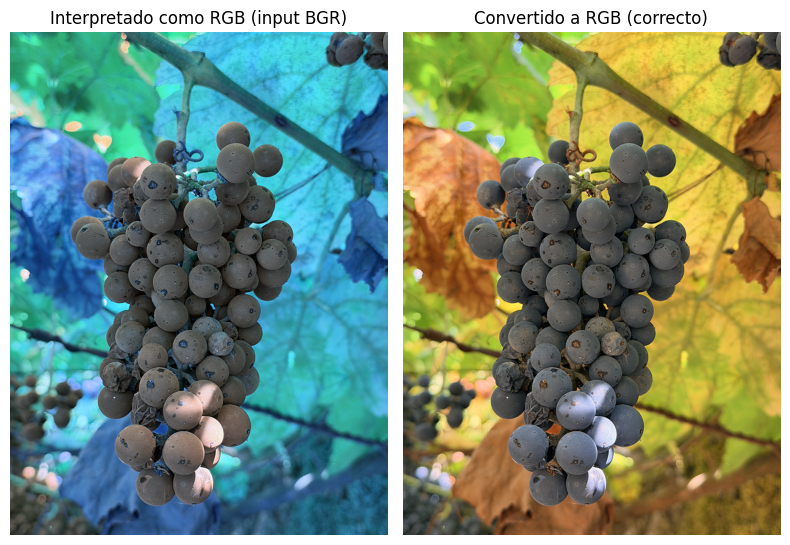

In [17]:
# RUTA DE ENTRADA
imgFolder = "./img/"
imgName = "IMG_1.jpg"

# LECTURA DE LA IMAGEN
img = cv2.imread(Path(imgFolder + imgName), cv2.IMREAD_COLOR)

# VISUALIZACION IMAGEN

fig, axes = plt.subplots(1, 2, figsize=(8,6))

# Izquierda: mostrar el array en BGR (incorrecto en Matplotlib, pero lo forzamos para ilustrar la diferencia)
axes[0].imshow(img)  # interpretado como RGB => colores "raros" porque el array está en BGR
axes[0].set_title('Interpretado como RGB (input BGR)')
axes[0].axis('off')

# Derecha: conversión BGR->RGB correcta
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
axes[1].imshow(img_rgb)
axes[1].set_title('Convertido a RGB (correcto)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

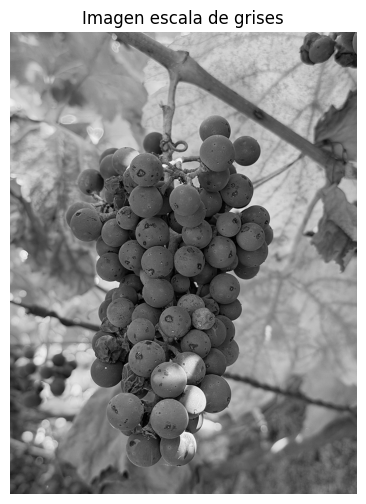

In [20]:
# TRANSFORMACIÓN A ESCALA DE GRISES
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# VISUALIZACION IMAGEN
plt.figure()
plt.imshow(img_gray, cmap="gray")
plt.title("Imagen escala de grises")
plt.axis('off')
plt.show()

# Generamos una imagen sintética de prueba (gradiente + círculo) y la guardamos
#synthetic = np.zeros((240, 320, 3), dtype=np.uint8)
#for y in range(synthetic.shape[0]):
    #synthetic[y, :, 1] = np.uint8(255 * y / synthetic.shape[0])  # canal G con gradiente vertical
#cv2.circle(synthetic, center=(160,120), radius=60, color=(255, 0, 0), thickness=-1)  # BGR: azul lleno

#out_dir = Path('./img')
#out_dir.mkdir(parents=True, exist_ok=True)
#synthetic_path = out_dir / 'synthetic.jpg'
#cv2.imwrite(str(synthetic_path), synthetic)
#synthetic_path


## 3. E/S de imágenes: `imread`, `imwrite` y comprobaciones básicas


In [ ]:

# RUTA DE ENTRADA: cambia 'synthetic_path' por tu imagen si lo deseas
img_path = str(synthetic_path)  # por defecto usamos la imagen sintética
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

if img is None:
    raise FileNotFoundError(f"No se pudo leer la imagen en {img_path}. Comprueba la ruta y permisos.")

print('dtype:', img.dtype)
print('shape (H, W, C):', img.shape)
print('strides (bytes):', img.strides)  # NumPy muestra strides en bytes

# Guardamos una copia
saved_path = str(out_dir / 'copy_saved.png')
cv2.imwrite(saved_path, img)
print('Guardada copia en:', saved_path)



## 4. Visualización: BGR vs. RGB en la **misma celda**
OpenCV usa **BGR**, mientras que Matplotlib espera **RGB**. Debemos convertir antes de mostrar.


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Izquierda: mostrar el array en BGR (incorrecto en Matplotlib, pero lo forzamos para ilustrar la diferencia)
axes[0].imshow(img)  # interpretado como RGB => colores "raros" porque el array está en BGR
axes[0].set_title('Interpretado como RGB (input BGR)')
axes[0].axis('off')

# Derecha: conversión BGR->RGB correcta
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
axes[1].imshow(img_rgb)
axes[1].set_title('Convertido a RGB (correcto)')
axes[1].axis('off')

plt.tight_layout()
plt.show()



### Conversión a GRAY y verificación de canales


In [ ]:

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print('GRAY dtype:', gray.dtype, 'shape:', gray.shape)  # H, W
plt.imshow(gray, cmap='gray'); plt.title('GRAY'); plt.axis('off'); plt.show()



## 5. ROI, **vista** vs. **copia**
Una **ROI** con slicing NumPy suele ser **vista** (comparte memoria). Si modificas la vista, se modifica el original. Usa `.copy()` si quieres aislarla.


In [ ]:

h, w = img.shape[:2]
roi = img[h//4: 3*h//4, w//4: 3*w//4]       # ROI central (vista)
roi_copy = roi.copy()                       # copia independiente

# Modificamos la vista: dibujamos un rectángulo rojo (BGR: (0,0,255)) en la ROI
cv2.rectangle(roi, (5,5), (roi.shape[1]-6, roi.shape[0]-6), (0,0,255), 2)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); axes[0].set_title('Imagen (modificada vía ROI)'); axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)); axes[1].set_title('ROI (vista)'); axes[1].axis('off')
axes[2].imshow(cv2.cvtColor(roi_copy, cv2.COLOR_BGR2RGB)); axes[2].set_title('ROI copy (aislada)'); axes[2].axis('off')
plt.tight_layout(); plt.show()



## 6. Strides: cómo se recorre la memoria
Las **strides** son el número de **bytes** que hay que saltar para avanzar una unidad en cada eje. En una imagen `H×W×C` `uint8`, típicamente:
- `stride_H = W*C` bytes para saltar a la siguiente fila,
- `stride_W = C` bytes para pasar al siguiente pixel en la fila,
- `stride_C = 1` byte para pasar al siguiente canal del mismo pixel.


In [ ]:

print("Strides img:", img.strides, " (bytes)")
print("dtype itemsize:", img.dtype.itemsize, "byte(s)")
print("Comprobación W*C:", img.shape[1]*img.shape[2], "vs stride fila en bytes:", img.strides[0])



## 7. Vídeo con `cv2.VideoCapture`
Abrimos un archivo o webcam. En entornos sin cámara, este bloque simplemente informará y continuará.


In [ ]:

# Intenta abrir webcam; si falla, informa. En tu entorno, cambia por un archivo de vídeo si lo deseas.
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("No se pudo abrir la cámara. Prueba con un archivo de vídeo en su lugar.")
else:
    ret, frame = cap.read()
    cap.release()
    if ret:
        print("Frame leído:", frame.shape, frame.dtype)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)); plt.title('Primer frame'); plt.axis('off'); plt.show()
    else:
        print("No se pudo leer un frame de la cámara.")



## 8. Cronometría: copia vs. vista
Medimos tiempo de **copiar** (`.copy()`) frente a obtener una **vista** (slicing).


In [ ]:

import timeit

setup = "import numpy as np; import cv2; img=np.random.randint(0,256,(1080,1920,3),dtype=np.uint8)"
time_copy = timeit.timeit("roi=img[100:900,200:1700].copy()", setup=setup, number=50)
time_view = timeit.timeit("roi=img[100:900,200:1700]", setup=setup, number=50)
print(f"Copia: {time_copy:.6f} s (50 iters)")
print(f"Vista: {time_view:.6f} s (50 iters)")



## 9. **Stretch**: `safe_imread` (cargas con validación y errores con causa)
Implementamos una función robusta para leer imágenes que:
- Valida la ruta y la existencia del archivo,
- Intenta leer en modo color/gray según parámetro,
- Devuelve `(img, None)` si todo va bien; o `(None, error_message)` si algo falla.


In [ ]:

from typing import Optional, Tuple, Literal

def safe_imread(path: str, mode: Literal['color','gray']='color') -> Tuple[Optional[np.ndarray], Optional[str]]:
    """Lee una imagen con validación de ruta y errores con causa.
    
    Parameters
    ----------
    path : str
        Ruta al archivo de imagen.
    mode : {'color','gray'}
        Modo de lectura. 'color' => BGR, 'gray' => escala de grises.
    
    Returns
    -------
    (img, err) : Tuple[Optional[np.ndarray], Optional[str]]
        img: np.ndarray si ok; None si falla.
        err: None si ok; string con causa si falla.
    """
    if not isinstance(path, (str, Path)):
        return None, "El parámetro 'path' debe ser str o Path."
    p = Path(path)
    if not p.exists():
        return None, f"El archivo no existe: {p}"
    if not p.is_file():
        return None, f"La ruta no es un archivo: {p}"
    
    flag = cv2.IMREAD_COLOR if mode == 'color' else cv2.IMREAD_GRAYSCALE
    img = cv2.imread(str(p), flag)
    if img is None:
        return None, "cv2.imread devolvió None. Puede ser un formato no soportado o un archivo corrupto."
    return img, None

# Prueba con nuestra imagen sintética
ok_img, err = safe_imread(synthetic_path, mode='color')
print("OK:", ok_img is not None, "| Error:", err)



## 10. Ejercicios (con soluciones ocultables)

**Ejercicio 1.** Carga una imagen desde disco, imprime su `dtype`, `shape` y `strides`.  
**Ejercicio 2.** Muestra la misma imagen en BGR y en RGB en una **misma salida** con subplots.  
**Ejercicio 3.** Extrae una ROI central como **vista**, dibuja un rectángulo y verifica que se modifica la imagen original. Repite con `.copy()` y verifica que **no** afecta al original.  
**Ejercicio 4.** Convierte tu imagen a GRAY y guarda el resultado en PNG.  
**Ejercicio 5.** Mide el tiempo (con `timeit`) de crear una vista vs. una copia para una ROI grande.

<details>
<summary><b>Solución (mostrar/ocultar)</b></summary>

```python
# Ejercicio 1
img2, err = safe_imread(synthetic_path)
assert err is None
print(img2.dtype, img2.shape, img2.strides)

# Ejercicio 2
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].imshow(img2)  # BGR mal interpretado como RGB
axes[0].set_title('Interpretado como RGB (input BGR)'); axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[1].set_title('Convertido a RGB'); axes[1].axis('off')
plt.tight_layout(); plt.show()

# Ejercicio 3
h, w = img2.shape[:2]
roi_v = img2[h//4:3*h//4, w//4:3*w//4]  # vista
cv2.rectangle(roi_v, (5,5), (roi_v.shape[1]-6, roi_v.shape[0]-6), (0,255,0), 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); plt.title('Original modificado'); plt.axis('off'); plt.show()

img2b = img2.copy()
roi_c = img2b[h//4:3*h//4, w//4:3*w//4].copy()  # copia
cv2.circle(roi_c, (roi_c.shape[1]//2, roi_c.shape[0]//2), 20, (255,0,255), 2)
# No afecta a img2b
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(cv2.cvtColor(img2b, cv2.COLOR_BGR2RGB)); ax[0].set_title('Original (intacto)'); ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(roi_c, cv2.COLOR_BGR2RGB)); ax[1].set_title('ROI copia (modificada)'); ax[1].axis('off')
plt.tight_layout(); plt.show()

# Ejercicio 4
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
out_gray = str(out_dir / 'resultado_gray.png')
cv2.imwrite(out_gray, gray2)

# Ejercicio 5
import timeit
setup = "import numpy as np; img=np.random.randint(0,256,(1080,1920,3),dtype=np.uint8)"
print('copy:', timeit.timeit("roi=img[100:900,200:1700].copy()", setup=setup, number=50))
print('view:', timeit.timeit("roi=img[100:900,200:1700]", setup=setup, number=50))
```
</details>



## 11. Lecturas y referencias

- Documentación oficial de OpenCV (Python): https://docs.opencv.org/
- Tutoriales (OpenCV-Python Tutorials): https://docs.opencv.org/master/d6/d00/tutorial_py_root.html
- NumPy: https://numpy.org/doc/stable/
- sRGB vs. linear (curva gamma): especificación sRGB IEC 61966-2-1; explicación práctica: https://entropymine.com/imageworsener/gamma/
- Matplotlib (para visualización): https://matplotlib.org/stable/



## Anexo: `imshow(title, img, bgr=True)`
Una utilidad habitual para evitar errores de conversión de color.


In [ ]:

def imshow(title, img, bgr=True):
    plt.figure()
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        if bgr:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Ejemplo en una MISMA celda: mostrar BGR y RGB lado a lado usando la función
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].imshow(img)  # BGR mal interpretado como RGB
axes[0].set_title('BGR interpretado como RGB'); axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[1].set_title('RGB correcto'); axes[1].axis('off')
plt.tight_layout(); plt.show()
